# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim 

import time
import os
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
vgg19 = models.vgg19(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Preparing Data

In [ ]:
# For feature extraction. (Run only once)
jeff_dir = '/content/drive/MyDrive/APS360-Project/Datasets/Dataset_3'
# Choose path
data_dir = jeff_dir

# define training and test data directories
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'validation/')
test_dir = os.path.join(data_dir, 'test/')
data_transform = transforms.Compose([transforms.Resize(224), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                     ])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

In [ ]:
# Save vgg19 features to drive (run only once)
"""
main_path = '/content/drive/MyDrive/APS360-Project/Models/VGG/features/'
if not os.path.isdir(main_path):
    os.mkdir(main_path)

for loc in ['train','val','test']:
    path = main_path + loc  
    if not os.path.isdir(path):
        os.mkdir(path)  
    # Prepare Dataloader
    batch_size = 1
    num_workers = 1
    if loc == 'train':
        loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                              num_workers=num_workers, shuffle=True)
    elif loc == 'val':
        loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                              num_workers=num_workers, shuffle=True)
    elif loc == 'test':
        loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                              num_workers=num_workers, shuffle=True)    
    classes = ['disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] 
    # save features
    n = 0
    for img, label in loader:
        img = vgg19.features(img)
        img = torch.from_numpy(img.detach().numpy())        
        folder_name = path + '/' + str(classes[label])
        if not os.path.isdir(folder_name):
          os.mkdir(folder_name)
        torch.save(img.squeeze(0), folder_name + '/' + str(n) + '.tensor')
        n += 1
"""

"\nmain_path = '/content/drive/MyDrive/APS360-Project/Models/VGG/features/'\nif not os.path.isdir(main_path):\n    os.mkdir(main_path)\n\nfor loc in ['train','val','test']:\n    path = main_path + loc  \n    if not os.path.isdir(path):\n        os.mkdir(path)  \n    # Prepare Dataloader\n    batch_size = 1\n    num_workers = 1\n    if loc == 'train':\n        loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, \n                                              num_workers=num_workers, shuffle=True)\n    elif loc == 'val':\n        loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, \n                                              num_workers=num_workers, shuffle=True)\n    elif loc == 'test':\n        loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, \n                                              num_workers=num_workers, shuffle=True)    \n    classes = ['disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] \n    # save featur

In [ ]:
jeff_path = '/content/drive/MyDrive/APS360-Project/Models/VGG/features/'

main_path = jeff_path

dataset_train = torchvision.datasets.DatasetFolder(main_path+'train/', 
                                                   loader=torch.load, extensions=('.tensor'))
dataset_val = torchvision.datasets.DatasetFolder(main_path+'val/', 
                                                 loader=torch.load, extensions=('.tensor'))
dataset_test = torchvision.datasets.DatasetFolder(main_path+'test/', 
                                                  loader=torch.load, extensions=('.tensor'))

In [ ]:
use_cuda = True
!nvidia-smi

Tue Apr  5 20:21:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Helper Functions

In [ ]:
def get_stastics(model, data, batch_size):
  # Load data
  data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)

  correct, total = 0, 0
  running_corrects, running_loss = 0.0, 0
  criterion = nn.CrossEntropyLoss()

  for imgs, labels in data_loader:
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #############################################
    
    output = model(imgs)
    loss = criterion(output, labels)
    
    #select index with maximum prediction score
    preds = output.max(1, keepdim=True)[1]

    # Get Accuracy
    correct += preds.eq(labels.view_as(preds)).sum().item()
    total += imgs.shape[0]
    accuracy = correct / total

    # Get F1 score
    running_loss += loss.item() * imgs.size(0)
    running_corrects += torch.sum(preds == labels.data)

    from sklearn.metrics import f1_score

    f1_score = f1_score(labels.cpu().data, preds.cpu(), average='micro')

  return accuracy, f1_score

In [ ]:
def train(model, train_data, val_data, batch_size=64, learning_rate = 0.01, num_epochs=1):
  torch.manual_seed(1000) # set the random seed

  train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  iters, train_acc, val_acc, train_f1, val_f1 = np.zeros(num_epochs), np.zeros(num_epochs), np.zeros(num_epochs), np.zeros(num_epochs), np.zeros(num_epochs)

  # training
  n = 0 # the number of iterations
  start_time=time.time()
  for epoch in range(num_epochs):
    for imgs, labels in iter(train_loader):
    
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################
    
      out = model(imgs)             # forward pass
      loss = criterion(out, labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # a clean up step for PyTorch

    # save the current training statistics
    iters[epoch] = n

    train_acc[epoch], train_f1[epoch] = get_stastics(model, dataset_train, batch_size=batch_size) # compute training 
    val_acc[epoch], val_f1[epoch] = get_stastics(model, dataset_val, batch_size=batch_size)  # compute validation 

    n += 1

    print ("Epoch %d Finished." % epoch, "Time per Epoch: % 6.2f s. "% ((time.time()-start_time) / (epoch +1)), 
           "Validation Accuracy is", val_acc[epoch], ". Validation F1 score is", val_f1[epoch])

  # save models for later usage
  # model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, num_epochs)
  model_path = "/content/drive/MyDrive/APS360-Project/Models/VGG/model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, num_epochs)
  torch.save(model.state_dict(), model_path)

  end_time= time.time()
  
  # plotting
  plt.title("F1 Score Curve")
  plt.plot(iters, train_f1, label="Training")
  plt.plot(iters, val_f1, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("F1 Score")
  plt.legend(loc='best')
  plt.show()

  plt.title("Accuracy Curve")
  plt.plot(iters, train_acc, label="Training")
  plt.plot(iters, val_acc, label="Validation")    
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))
  print("Final Training F1 Score: {}".format(train_f1[-1]))
  print("Final Validation F1 Score: {}".format(val_f1[-1]))

# Models

## Linear classifiers

In [ ]:
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.name = 'ANNClassifier'
        self.fc = nn.Linear(512 * 7 * 7, 6)

    def forward(self, x):
        x = x.view(-1, 512 * 7 * 7) #flatten feature data
        return F.relu(self.fc(x))

In [ ]:
class ANN2(nn.Module):
    def __init__(self):
        super(ANN2, self).__init__()
        self.name = 'ANN2'
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)
        self.fc4 = nn.Linear(1000, 50)
        self.fc5 = nn.Linear(50, 6)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        flattened = x.view(-1, 512 * 7 * 7) #flatten feature data
        activation1 = F.relu(self.fc1(flattened))
        activation2 = F.relu(self.fc2(self.dropout(activation1)))
        activation3 = F.relu(self.fc3(self.dropout(activation2)))
        activation4 = F.relu(self.fc4(activation3))
        return self.fc5(activation4)

## Model 1

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Time per Epoch:  4720.55 s.  Validation Accuracy is 0.4418483904465213 . Validation F1 score is 0.46078431372549017
Epoch 1 Finished. Time per Epoch:  2380.90 s.  Validation Accuracy is 0.48624091381100726 . Validation F1 score is 0.5686274509803921
Epoch 2 Finished. Time per Epoch:  1601.04 s.  Validation Accuracy is 0.4914330218068536 . Validation F1 score is 0.5098039215686274
Epoch 3 Finished. Time per Epoch:  1211.18 s.  Validation Accuracy is 0.48130841121495327 . Validation F1 score is 0.5392156862745098
Epoch 4 Finished. Time per Epoch:  977.68 s.  Validation Accuracy is 0.5085669781931464 . Validation F1 score is 0.5098039215686274
Epoch 5 Finished. Time per Epoch:  821.77 s.  Validation Accuracy is 0.49428868120456904 . Validation F1 score is 0.4117647058823529
Epoch 6 Finished. Time per Epoch:  710.48 s.  Validation Accuracy is 0.4919522326064382 . Validation F1 score is 0.5
Epoch 7 Finished. Time per Epoch:  626.93 s

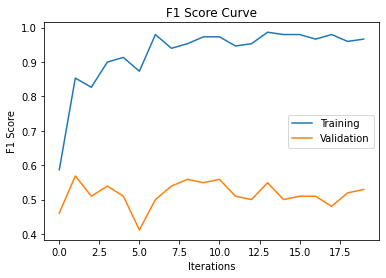

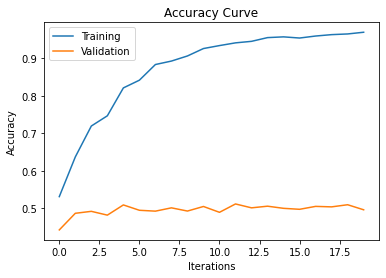

Final Training Accuracy: 0.9695555555555555
Final Validation Accuracy: 0.4955867082035306
Final Training F1 Score: 0.9666666666666667
Final Validation F1 Score: 0.5294117647058824


In [ ]:
# Model 1. 
model = ANN2()

if use_cuda and torch.cuda.is_available():
    torch.cuda.empty_cache()
    model.cuda()
    print('CUDA is available!  Training on GPU ...')

train(model, dataset_train, dataset_val, batch_size=150, learning_rate=0.001, num_epochs=20)

## Model 2

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Time per Epoch:  43.35 s.  Validation Accuracy is 0.45301142263759087 . Validation F1 score is 0.40196078431372545
Epoch 1 Finished. Time per Epoch:  43.03 s.  Validation Accuracy is 0.4937694704049844 . Validation F1 score is 0.5294117647058824
Epoch 2 Finished. Time per Epoch:  42.75 s.  Validation Accuracy is 0.5015576323987538 . Validation F1 score is 0.5098039215686274
Epoch 3 Finished. Time per Epoch:  42.78 s.  Validation Accuracy is 0.5002596053997923 . Validation F1 score is 0.47058823529411764
Epoch 4 Finished. Time per Epoch:  42.80 s.  Validation Accuracy is 0.4885773624091381 . Validation F1 score is 0.5980392156862745
Epoch 5 Finished. Time per Epoch:  42.79 s.  Validation Accuracy is 0.4932502596053998 . Validation F1 score is 0.5392156862745098
Epoch 6 Finished. Time per Epoch:  42.94 s.  Validation Accuracy is 0.5031152647975078 . Validation F1 score is 0.5294117647058824
Epoch 7 Finished. Time per Epoch:  42.91

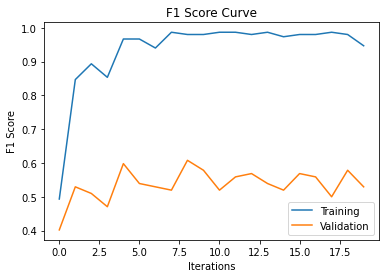

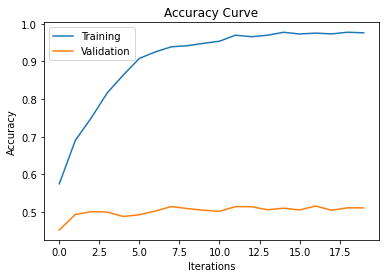

Final Training Accuracy: 0.9757222222222223
Final Validation Accuracy: 0.5114226375908619
Final Training F1 Score: 0.9466666666666667
Final Validation F1 Score: 0.5294117647058824


In [ ]:
# Model 2

model2 = ANN2()

if use_cuda and torch.cuda.is_available():
    torch.cuda.empty_cache()
    model2.cuda()
    print('CUDA is available!  Training on GPU ...')

train(model2, dataset_train, dataset_val, batch_size=150, learning_rate=0.0005, num_epochs=20)


## Model 3

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Time per Epoch:  44.95 s.  Validation Accuracy is 0.3901869158878505 . Validation F1 score is 0.5
Epoch 1 Finished. Time per Epoch:  43.93 s.  Validation Accuracy is 0.4709241952232606 . Validation F1 score is 0.5490196078431373
Epoch 2 Finished. Time per Epoch:  43.81 s.  Validation Accuracy is 0.48364485981308414 . Validation F1 score is 0.5196078431372549
Epoch 3 Finished. Time per Epoch:  43.49 s.  Validation Accuracy is 0.48286604361370716 . Validation F1 score is 0.5294117647058824
Epoch 4 Finished. Time per Epoch:  43.41 s.  Validation Accuracy is 0.48052959501557635 . Validation F1 score is 0.5
Epoch 5 Finished. Time per Epoch:  43.27 s.  Validation Accuracy is 0.4963655244029076 . Validation F1 score is 0.5196078431372549
Epoch 6 Finished. Time per Epoch:  43.32 s.  Validation Accuracy is 0.5012980269989615 . Validation F1 score is 0.5294117647058824
Epoch 7 Finished. Time per Epoch:  43.38 s.  Validation Accuracy is 0.

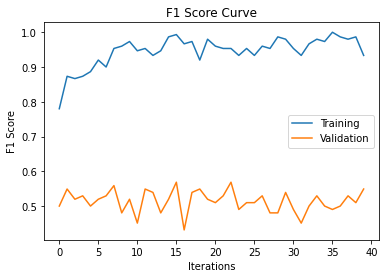

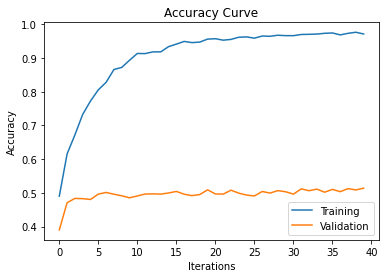

Final Training Accuracy: 0.9713888888888889
Final Validation Accuracy: 0.514018691588785
Final Training F1 Score: 0.9333333333333333
Final Validation F1 Score: 0.5490196078431373


In [ ]:
# Model 3

model3 = ANN2()

if use_cuda and torch.cuda.is_available():
    torch.cuda.empty_cache()
    model3.cuda()
    print('CUDA is available!  Training on GPU ...')

train(model3, dataset_train, dataset_val, batch_size = 150, learning_rate = 0.001, num_epochs = 40)

In [ ]:
acc, fs = get_stastics(model3, dataset_test, batch_size=150)

print("Test accuracy:", acc)
print("F1 score:", fs)

Test accuracy: 0.52466251298027
F1 score: 0.5588235294117647


## Model 4

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Time per Epoch:  43.96 s.  Validation Accuracy is 0.42471443406022846 . Validation F1 score is 0.40196078431372545
Epoch 1 Finished. Time per Epoch:  43.50 s.  Validation Accuracy is 0.4657320872274143 . Validation F1 score is 0.5882352941176471
Epoch 2 Finished. Time per Epoch:  43.30 s.  Validation Accuracy is 0.4771547248182762 . Validation F1 score is 0.5196078431372549
Epoch 3 Finished. Time per Epoch:  43.42 s.  Validation Accuracy is 0.49221183800623053 . Validation F1 score is 0.5882352941176471
Epoch 4 Finished. Time per Epoch:  43.30 s.  Validation Accuracy is 0.4779335410176532 . Validation F1 score is 0.5294117647058824
Epoch 5 Finished. Time per Epoch:  43.21 s.  Validation Accuracy is 0.4937694704049844 . Validation F1 score is 0.4803921568627451
Epoch 6 Finished. Time per Epoch:  43.18 s.  Validation Accuracy is 0.48468328141225336 . Validation F1 score is 0.4411764705882353
Epoch 7 Finished. Time per Epoch:  43.2

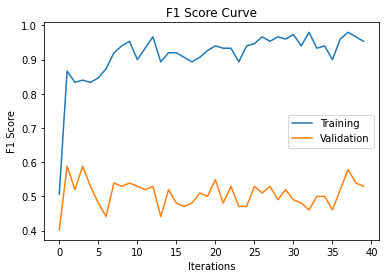

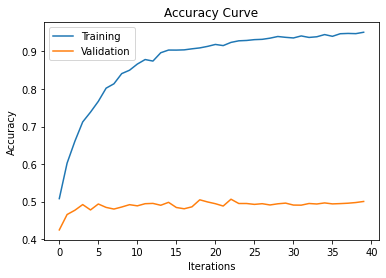

Final Training Accuracy: 0.9512777777777778
Final Validation Accuracy: 0.5005192107995846
Final Training F1 Score: 0.9533333333333334
Final Validation F1 Score: 0.5294117647058824


In [ ]:
# Model 4

model4 = ANN2()

if use_cuda and torch.cuda.is_available():
    torch.cuda.empty_cache()
    model4.cuda()
    print('CUDA is available!  Training on GPU ...')

train(model4, dataset_train, dataset_val, batch_size = 150, learning_rate = 0.001, num_epochs = 40)

## Model 5

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Time per Epoch:  54.38 s.  Validation Accuracy is 0.4688473520249221 . Validation F1 score is 0.4166666666666667
Epoch 1 Finished. Time per Epoch:  49.54 s.  Validation Accuracy is 0.46443406022845274 . Validation F1 score is 0.4166666666666667
Epoch 2 Finished. Time per Epoch:  47.52 s.  Validation Accuracy is 0.5012980269989615 . Validation F1 score is 0.25
Epoch 3 Finished. Time per Epoch:  46.49 s.  Validation Accuracy is 0.5059709241952233 . Validation F1 score is 0.4166666666666667
Epoch 4 Finished. Time per Epoch:  45.92 s.  Validation Accuracy is 0.4883177570093458 . Validation F1 score is 0.3333333333333333
Epoch 5 Finished. Time per Epoch:  45.51 s.  Validation Accuracy is 0.5036344755970924 . Validation F1 score is 0.3333333333333333
Epoch 6 Finished. Time per Epoch:  45.43 s.  Validation Accuracy is 0.4981827622014538 . Validation F1 score is 0.4166666666666667
Epoch 7 Finished. Time per Epoch:  45.22 s.  Validation 

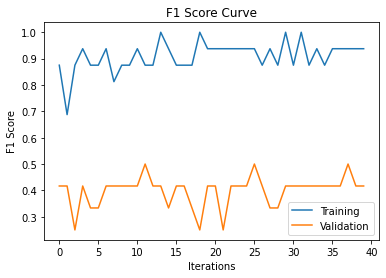

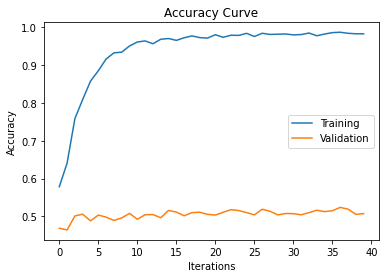

Final Training Accuracy: 0.9821111111111112
Final Validation Accuracy: 0.5075285565939771
Final Training F1 Score: 0.9375
Final Validation F1 Score: 0.4166666666666667


In [ ]:
# Model 5

model5 = ANN2()

if use_cuda and torch.cuda.is_available():
    torch.cuda.empty_cache()
    model5.cuda()
    print('CUDA is available!  Training on GPU ...')

train(model5, dataset_train, dataset_val, batch_size = 64, learning_rate = 0.0005, num_epochs = 40)

## Model 6

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Time per Epoch:  42.07 s.  Validation Accuracy is 0.48961578400830735 . Validation F1 score is 0.3333333333333333
Epoch 1 Finished. Time per Epoch:  42.38 s.  Validation Accuracy is 0.4914330218068536 . Validation F1 score is 0.4166666666666667
Epoch 2 Finished. Time per Epoch:  42.35 s.  Validation Accuracy is 0.5122014537902388 . Validation F1 score is 0.4166666666666667
Epoch 3 Finished. Time per Epoch:  42.42 s.  Validation Accuracy is 0.4963655244029076 . Validation F1 score is 0.3333333333333333
Epoch 4 Finished. Time per Epoch:  42.51 s.  Validation Accuracy is 0.4885773624091381 . Validation F1 score is 0.4166666666666667
Epoch 5 Finished. Time per Epoch:  42.60 s.  Validation Accuracy is 0.5088265835929388 . Validation F1 score is 0.4166666666666667
Epoch 6 Finished. Time per Epoch:  42.63 s.  Validation Accuracy is 0.5046728971962616 . Validation F1 score is 0.4166666666666667
Epoch 7 Finished. Time per Epoch:  42.59 s

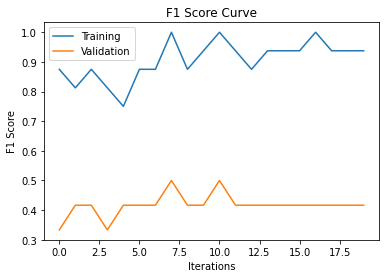

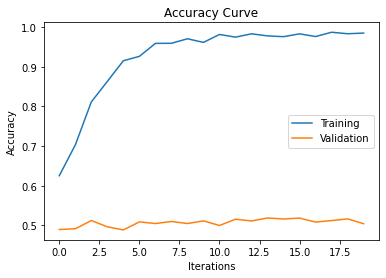

Final Training Accuracy: 0.9848888888888889
Final Validation Accuracy: 0.504153686396677
Final Training F1 Score: 0.9375
Final Validation F1 Score: 0.4166666666666667


In [ ]:
# Model 6
model6 = ANN2()

if use_cuda and torch.cuda.is_available():
    torch.cuda.empty_cache()
    model6.cuda()
    print('CUDA is available!  Training on GPU ...')

train(model6, dataset_train, dataset_val, batch_size = 64, learning_rate = 0.0001, num_epochs = 20)

## Model 7

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Time per Epoch:  43.59 s.  Validation Accuracy is 0.48234683281412255 . Validation F1 score is 0.3333333333333333
Epoch 1 Finished. Time per Epoch:  43.01 s.  Validation Accuracy is 0.4976635514018692 . Validation F1 score is 0.4166666666666667
Epoch 2 Finished. Time per Epoch:  42.90 s.  Validation Accuracy is 0.5036344755970924 . Validation F1 score is 0.4166666666666667
Epoch 3 Finished. Time per Epoch:  42.85 s.  Validation Accuracy is 0.4997403946002077 . Validation F1 score is 0.5
Epoch 4 Finished. Time per Epoch:  42.76 s.  Validation Accuracy is 0.5083073727933541 . Validation F1 score is 0.4166666666666667
Epoch 5 Finished. Time per Epoch:  42.67 s.  Validation Accuracy is 0.5109034267912772 . Validation F1 score is 0.4166666666666667
Epoch 6 Finished. Time per Epoch:  42.67 s.  Validation Accuracy is 0.504153686396677 . Validation F1 score is 0.4166666666666667
Epoch 7 Finished. Time per Epoch:  42.85 s.  Validation Ac

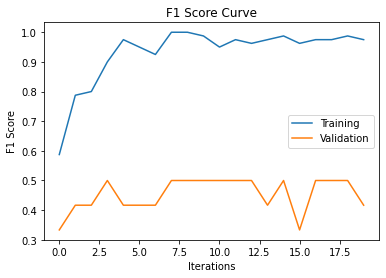

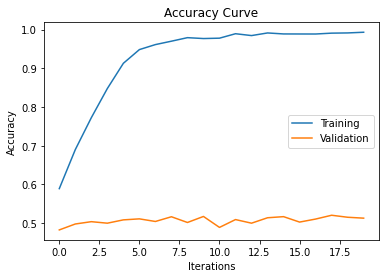

Final Training Accuracy: 0.9930555555555556
Final Validation Accuracy: 0.5127206645898235
Final Training F1 Score: 0.975
Final Validation F1 Score: 0.4166666666666667


In [ ]:
# Model 7
model7 = ANN2()

if use_cuda and torch.cuda.is_available():
    torch.cuda.empty_cache()
    model7.cuda()
    print('CUDA is available!  Training on GPU ...')

train(model7, dataset_train, dataset_val, batch_size = 128, learning_rate = 0.00005, num_epochs = 20)

## Model 8

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Time per Epoch:  42.79 s.  Validation Accuracy is 0.2897196261682243 . Validation F1 score is 0.4166666666666667
Epoch 1 Finished. Time per Epoch:  42.57 s.  Validation Accuracy is 0.4184839044652129 . Validation F1 score is 0.3333333333333333
Epoch 2 Finished. Time per Epoch:  42.65 s.  Validation Accuracy is 0.4488577362409138 . Validation F1 score is 0.3333333333333333
Epoch 3 Finished. Time per Epoch:  42.52 s.  Validation Accuracy is 0.4755970924195223 . Validation F1 score is 0.3333333333333333
Epoch 4 Finished. Time per Epoch:  42.57 s.  Validation Accuracy is 0.48286604361370716 . Validation F1 score is 0.3333333333333333
Epoch 5 Finished. Time per Epoch:  42.56 s.  Validation Accuracy is 0.48624091381100726 . Validation F1 score is 0.4166666666666667
Epoch 6 Finished. Time per Epoch:  42.60 s.  Validation Accuracy is 0.4948078920041537 . Validation F1 score is 0.3333333333333333
Epoch 7 Finished. Time per Epoch:  42.83 

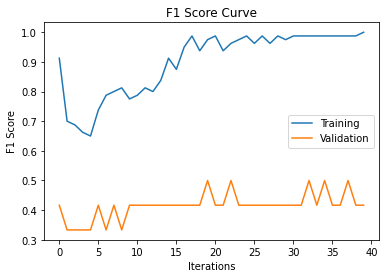

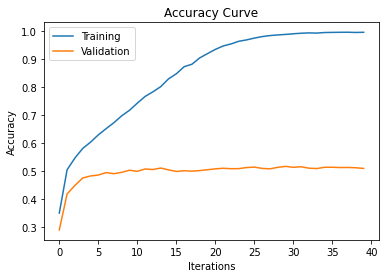

Final Training Accuracy: 0.9971111111111111
Final Validation Accuracy: 0.509865005192108
Final Training F1 Score: 1.0
Final Validation F1 Score: 0.4166666666666667


In [ ]:
# Model 8
model8 = ANN2()

if use_cuda and torch.cuda.is_available():
    torch.cuda.empty_cache()
    model8.cuda()
    print('CUDA is available!  Training on GPU ...')

train(model8, dataset_train, dataset_val, batch_size = 128, learning_rate = 0.000005, num_epochs = 40)

## Model 9

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Time per Epoch:  42.40 s.  Validation Accuracy is 0.2827102803738318 . Validation F1 score is 0.5
Epoch 1 Finished. Time per Epoch:  41.92 s.  Validation Accuracy is 0.34761163032191067 . Validation F1 score is 0.5
Epoch 2 Finished. Time per Epoch:  42.06 s.  Validation Accuracy is 0.40109034267912774 . Validation F1 score is 0.5
Epoch 3 Finished. Time per Epoch:  42.30 s.  Validation Accuracy is 0.43094496365524404 . Validation F1 score is 0.5
Epoch 4 Finished. Time per Epoch:  42.25 s.  Validation Accuracy is 0.43795430944963654 . Validation F1 score is 0.5
Epoch 5 Finished. Time per Epoch:  42.18 s.  Validation Accuracy is 0.45560747663551404 . Validation F1 score is 0.5
Epoch 6 Finished. Time per Epoch:  42.13 s.  Validation Accuracy is 0.46936656282450673 . Validation F1 score is 0.5
Epoch 7 Finished. Time per Epoch:  42.12 s.  Validation Accuracy is 0.4717030114226376 . Validation F1 score is 0.5
Epoch 8 Finished. Time per

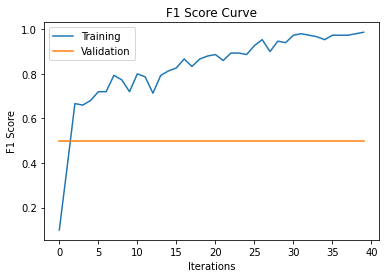

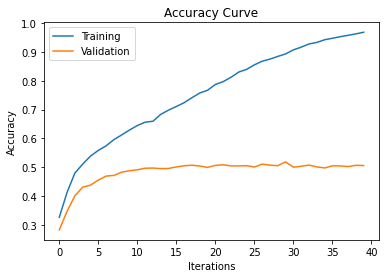

Final Training Accuracy: 0.9681666666666666
Final Validation Accuracy: 0.5059709241952233
Final Training F1 Score: 0.9866666666666668
Final Validation F1 Score: 0.5


In [ ]:
model9 = ANN2()

if use_cuda and torch.cuda.is_available():
    torch.cuda.empty_cache()
    model9.cuda()
    print('CUDA is available!  Training on GPU ...')

train(model9, dataset_train, dataset_val, batch_size = 350, learning_rate = 0.000005, num_epochs = 40)

## Model 10

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Time per Epoch:  86.55 s.  Validation Accuracy is 0.465472481827622 . Validation F1 score is 0.5
Epoch 1 Finished. Time per Epoch:  86.29 s.  Validation Accuracy is 0.48572170301142265 . Validation F1 score is 0.5
Epoch 2 Finished. Time per Epoch:  86.12 s.  Validation Accuracy is 0.5059709241952233 . Validation F1 score is 0.5
Epoch 3 Finished. Time per Epoch:  86.27 s.  Validation Accuracy is 0.5127206645898235 . Validation F1 score is 0.5
Epoch 4 Finished. Time per Epoch:  86.27 s.  Validation Accuracy is 0.505711318795431 . Validation F1 score is 0.5
Epoch 5 Finished. Time per Epoch:  86.25 s.  Validation Accuracy is 0.5059709241952233 . Validation F1 score is 0.5
Epoch 6 Finished. Time per Epoch:  86.19 s.  Validation Accuracy is 0.5072689511941848 . Validation F1 score is 0.5
Epoch 7 Finished. Time per Epoch:  86.18 s.  Validation Accuracy is 0.5127206645898235 . Validation F1 score is 0.5
Epoch 8 Finished. Time per Epoch:

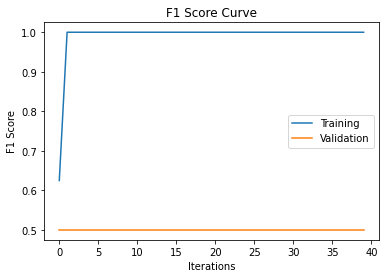

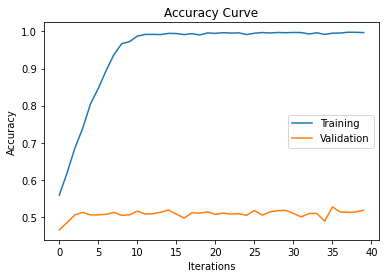

Final Training Accuracy: 0.9966666666666667
Final Validation Accuracy: 0.5184319833852544
Final Training F1 Score: 1.0
Final Validation F1 Score: 0.5


In [ ]:
model10 = ANN2()

if use_cuda and torch.cuda.is_available():
    torch.cuda.empty_cache()
    model10.cuda()
    print('CUDA is available!  Training on GPU ...')

train(model10, dataset_train, dataset_val, batch_size = 8, learning_rate = 0.000005, num_epochs = 40)

## Second ANN classifier, reduced parameters to prevent overfitting

In [ ]:
class ANN3(nn.Module):
    def __init__(self):
        super(ANN3, self).__init__()
        self.name = 'ANN2'
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, 6)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        flattened = x.view(-1, 512 * 7 * 7) #flatten feature data
        activation1 = F.relu(self.fc1(flattened))
        activation2 = F.relu(self.fc2(self.dropout(activation1)))
        return self.fc3(activation2)

## Model 11

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Time per Epoch:  42.84 s.  Validation Accuracy is 0.44781931464174457 . Validation F1 score is 0.3333333333333333
Epoch 1 Finished. Time per Epoch:  42.94 s.  Validation Accuracy is 0.470404984423676 . Validation F1 score is 0.3333333333333333
Epoch 2 Finished. Time per Epoch:  43.16 s.  Validation Accuracy is 0.48286604361370716 . Validation F1 score is 0.3333333333333333
Epoch 3 Finished. Time per Epoch:  43.28 s.  Validation Accuracy is 0.49584631360332293 . Validation F1 score is 0.3333333333333333
Epoch 4 Finished. Time per Epoch:  43.29 s.  Validation Accuracy is 0.5062305295950156 . Validation F1 score is 0.3333333333333333
Epoch 5 Finished. Time per Epoch:  43.46 s.  Validation Accuracy is 0.5080477673935618 . Validation F1 score is 0.3333333333333333
Epoch 6 Finished. Time per Epoch:  43.49 s.  Validation Accuracy is 0.5129802699896158 . Validation F1 score is 0.5
Epoch 7 Finished. Time per Epoch:  43.48 s.  Validation 

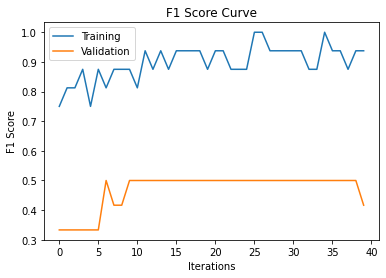

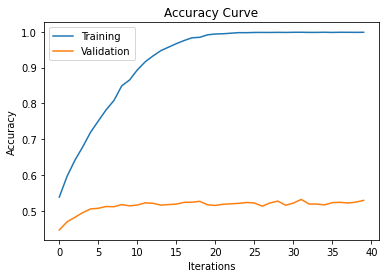

Final Training Accuracy: 0.9982777777777778
Final Validation Accuracy: 0.5301142263759087
Final Training F1 Score: 0.9375
Final Validation F1 Score: 0.4166666666666667


In [ ]:
model11 = ANN3()

if use_cuda and torch.cuda.is_available():
    torch.cuda.empty_cache()
    model11.cuda()
    print('CUDA is available!  Training on GPU ...')

train(model11, dataset_train, dataset_val, batch_size = 64, learning_rate = 0.000005, num_epochs = 40)

In [ ]:
acc, fs = get_stastics(model11, dataset_test, batch_size=64)

print("Test accuracy:", acc)
print("F1 score:", fs)

Test accuracy: 0.5428348909657321
F1 score: 0.5833333333333334


## Model 12

CUDA is available!  Training on GPU ...
Epoch 0 Finished. Time per Epoch:  6258.87 s.  Validation Accuracy is 0.4766355140186916 . Validation F1 score is 0.3333333333333333
Epoch 1 Finished. Time per Epoch:  3151.06 s.  Validation Accuracy is 0.505711318795431 . Validation F1 score is 0.4166666666666667
Epoch 2 Finished. Time per Epoch:  2115.45 s.  Validation Accuracy is 0.5023364485981309 . Validation F1 score is 0.5
Epoch 3 Finished. Time per Epoch:  1597.82 s.  Validation Accuracy is 0.5158359293873312 . Validation F1 score is 0.4166666666666667
Epoch 4 Finished. Time per Epoch:  1287.31 s.  Validation Accuracy is 0.5184319833852544 . Validation F1 score is 0.4166666666666667
Epoch 5 Finished. Time per Epoch:  1080.43 s.  Validation Accuracy is 0.5194704049844237 . Validation F1 score is 0.5
Epoch 6 Finished. Time per Epoch:  932.33 s.  Validation Accuracy is 0.5168743509865005 . Validation F1 score is 0.4166666666666667
Epoch 7 Finished. Time per Epoch:  821.27 s.  Validation Accu

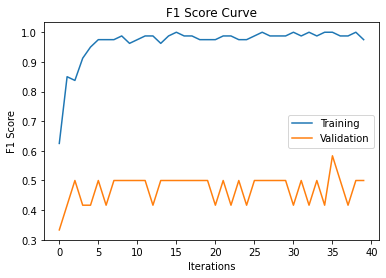

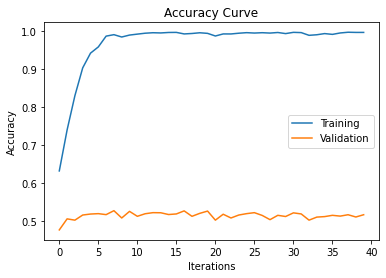

Final Training Accuracy: 0.9966111111111111
Final Validation Accuracy: 0.5166147455867082
Final Training F1 Score: 0.975
Final Validation F1 Score: 0.5


In [ ]:
model12 = ANN3()

if use_cuda and torch.cuda.is_available():
    torch.cuda.empty_cache()
    model12.cuda()
    print('CUDA is available!  Training on GPU ...')
          
train(model12, dataset_train, dataset_val, batch_size = 128, learning_rate = 0.00005, num_epochs = 40)

In [ ]:
acc, fs = get_stastics(model12, dataset_test, batch_size=64)

print("Test accuracy:", acc)
print("F1 score:", fs)